# Brexit synthetic control example

NOTE: I ran `pip install git+https://github.com/pymc-labs/CausalPy.git` to get the development version. The current release if 0.0.4, so I'm using a later (development) version than this.

In [1]:
import arviz as az
import causalpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-white")

## Import and process data

In [3]:
df = (
    cp.load_data("brexit")
    .assign(Time=lambda x: pd.to_datetime(x["Time"]))
    .set_index("Time")
    .query("index > 2009")
)

# specify date of the Brexit vote announcement
treatment_time = pd.to_datetime("2016 June 24")

In [4]:
# manual exclusion of some countries
df = df.drop(["Japan", "Italy", "US", "Spain"], axis=1)

In [5]:
# get useful country lists
target_country = "UK"
all_countries = df.columns
other_countries = all_countries.difference({target_country})
all_countries = list(all_countries)
other_countries = list(other_countries)

## Data visualisation

In [6]:
az.style.use("arviz-white")

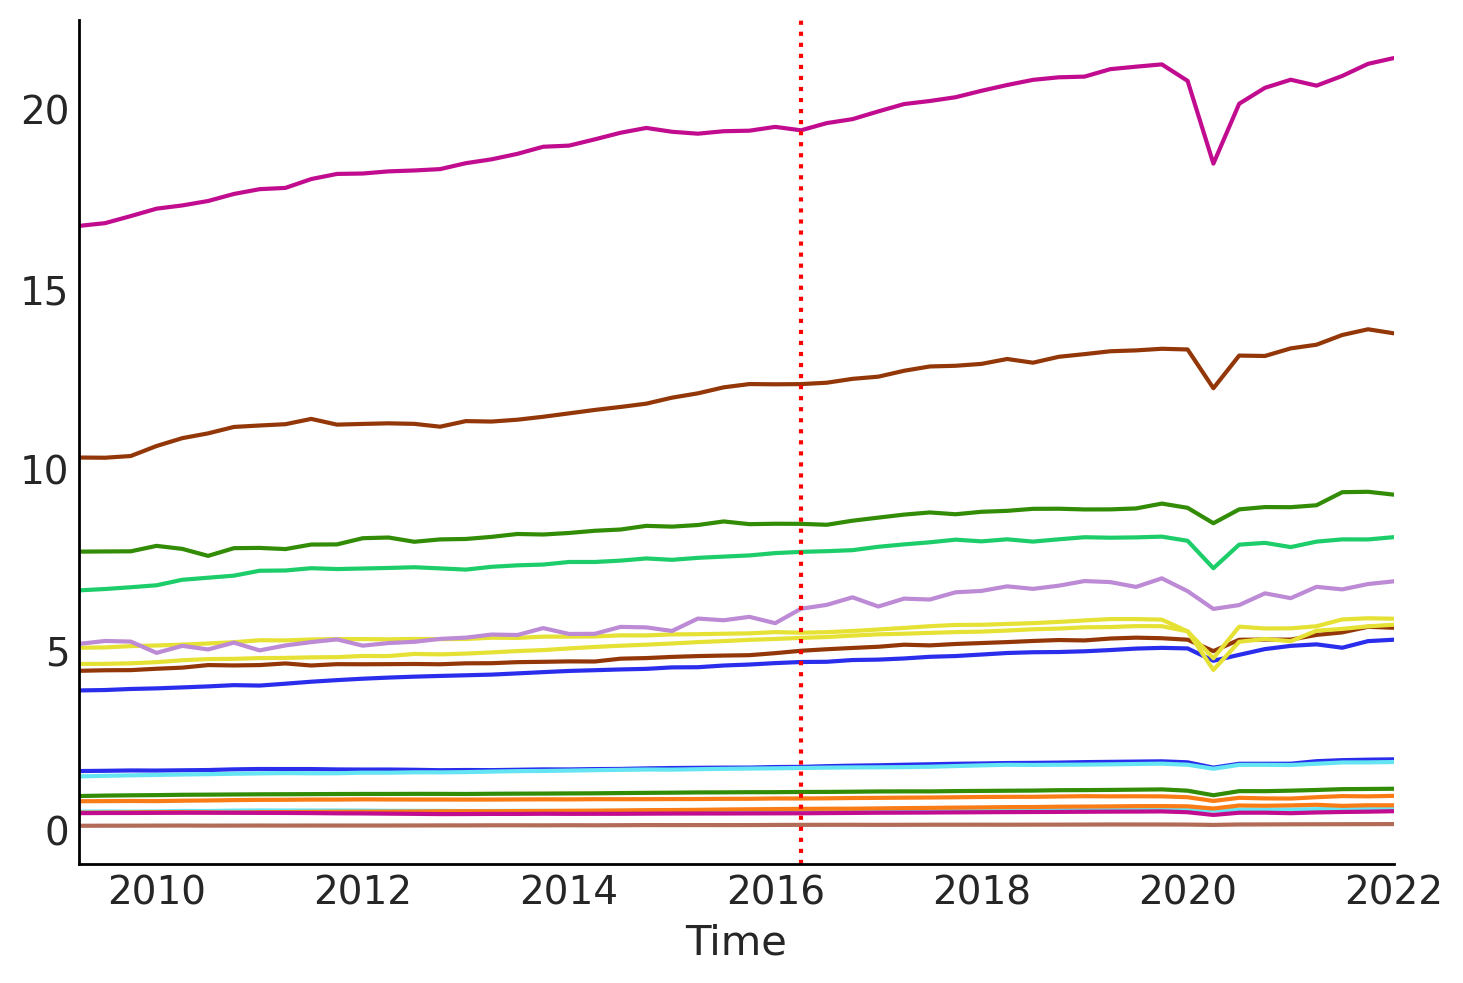

In [7]:
ax = df.plot(legend=False)
ax.axvline(x=treatment_time, color="r", ls=":");

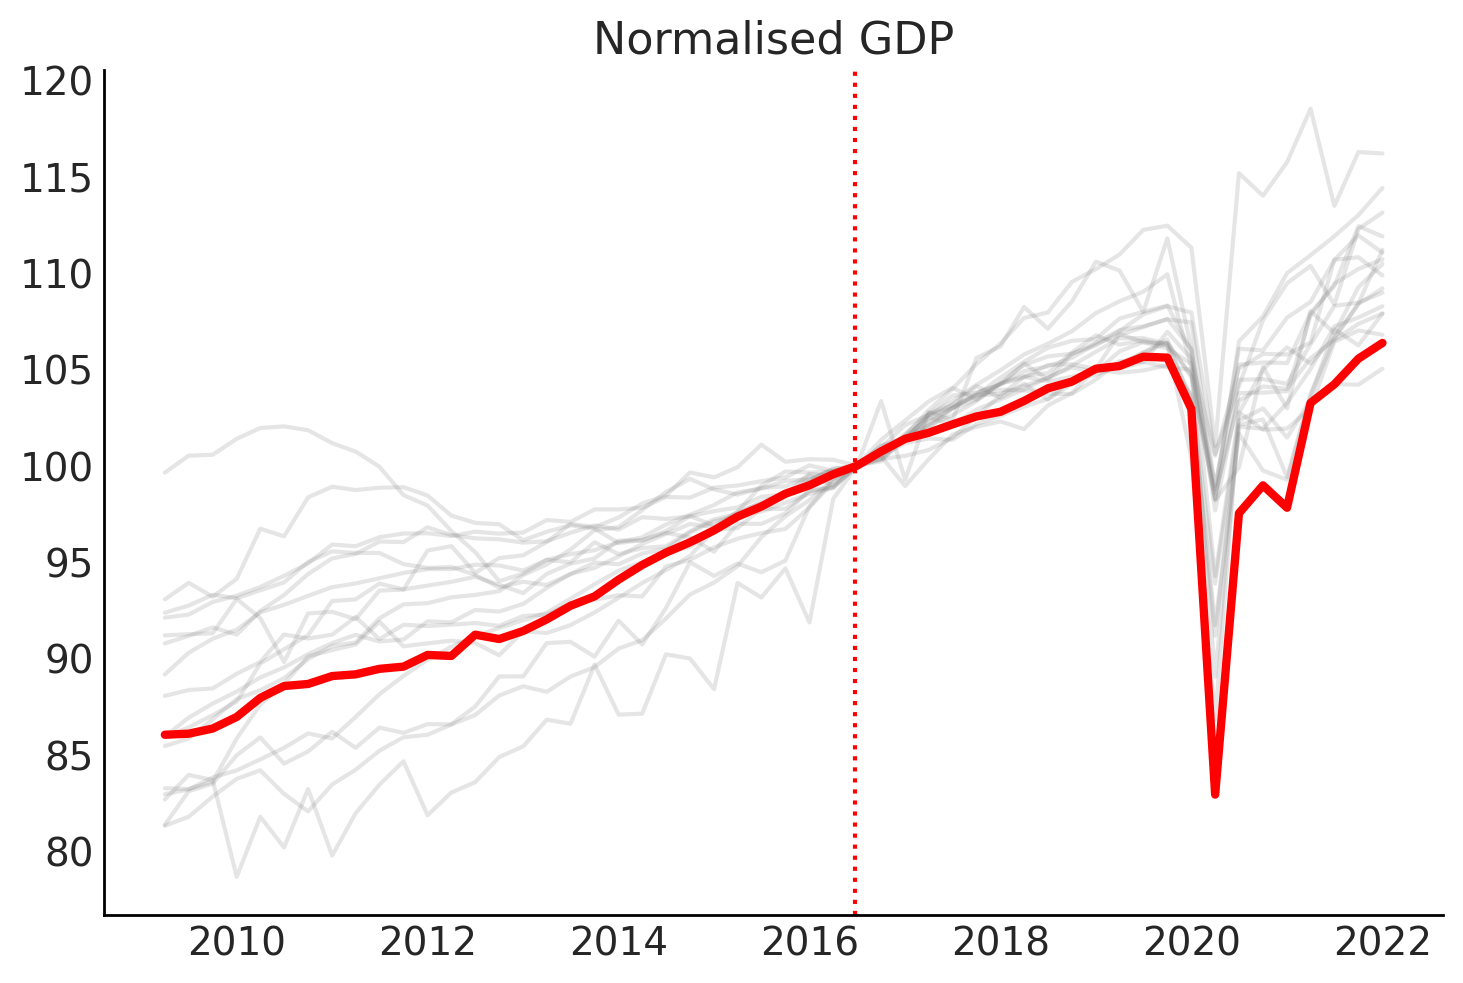

In [8]:
# Plot the time series normalised so that intervention point (Q3 2016) is equal to 100
gdp_at_intervention = df.loc[pd.to_datetime("2016 July 01"), :]
df_normalised = (df / gdp_at_intervention) * 100.0

# plot
fig, ax = plt.subplots()
for col in other_countries:
    ax.plot(df_normalised.index, df_normalised[col], color="grey", alpha=0.2)

ax.plot(df_normalised.index, df_normalised[target_country], color="red", lw=3)
# ax = df_normalised.plot(legend=False)

# formatting
ax.set(title="Normalised GDP")
ax.axvline(x=treatment_time, color="r", ls=":")

plt.savefig("img/brexit_GDP_normalised.png", bbox_inches="tight", dpi=300);

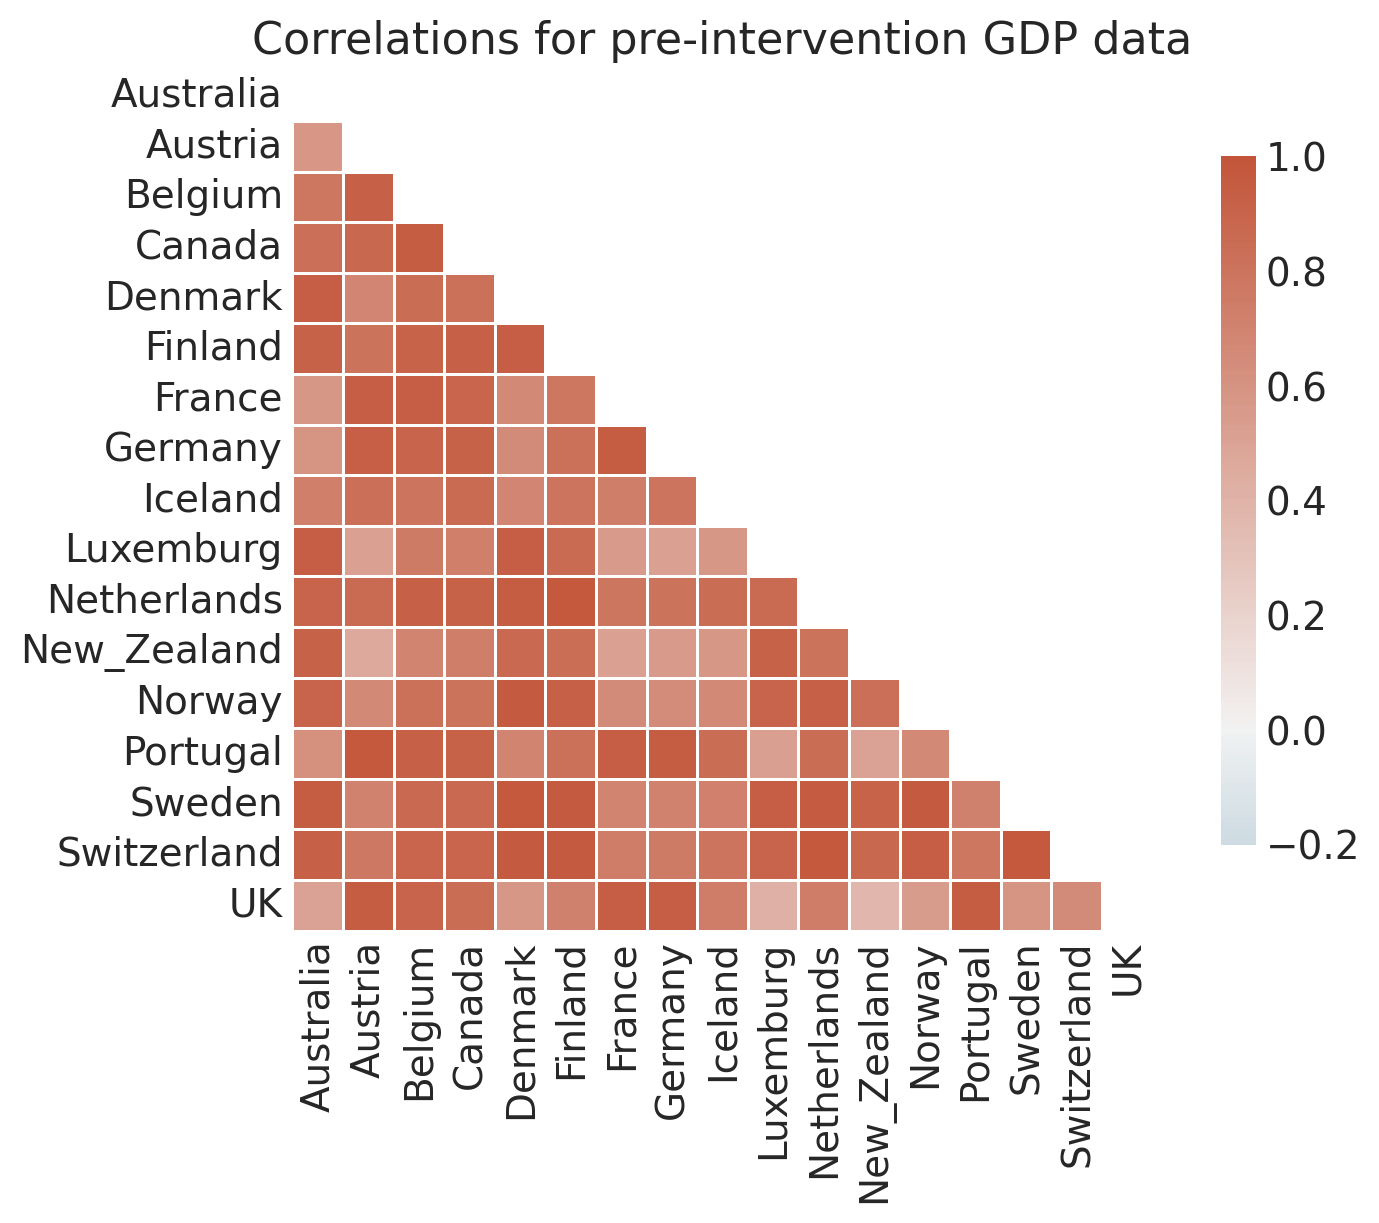

In [9]:
# Examine how correlated the pre-intervention time series are

pre_intervention_data = df.loc[df.index > treatment_time, :]

corr = pre_intervention_data.corr()

f, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(
    corr,
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    cmap=sns.diverging_palette(230, 20, as_cmap=True),
    vmin=-0.2,
    vmax=1.0,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
ax.set(title="Correlations for pre-intervention GDP data")
plt.savefig("img/brexit_pre_intervention_correlations.png", bbox_inches="tight");

## Run Bayesian synthetic control with `CausalPy`

In [10]:
formula = target_country + " ~ " + "0 + " + " + ".join(other_countries)

print(formula)

UK ~ 0 + Australia + Austria + Belgium + Canada + Denmark + Finland + France + Germany + Iceland + Luxemburg + Netherlands + New_Zealand + Norway + Portugal + Sweden + Switzerland


In [11]:
result = cp.pymc_experiments.SyntheticControl(
    df,
    treatment_time,
    formula=formula,
    prediction_model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"tune": 4000, "target_accept": 0.99}
    ),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 285 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


/Users/benjamv/mambaforge/envs/whatif/lib/python3.11/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/benjamv/mambaforge/envs/whatif/lib/python3.11/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/benjamv/mambaforge/envs/whatif/lib/python3.11/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, mul

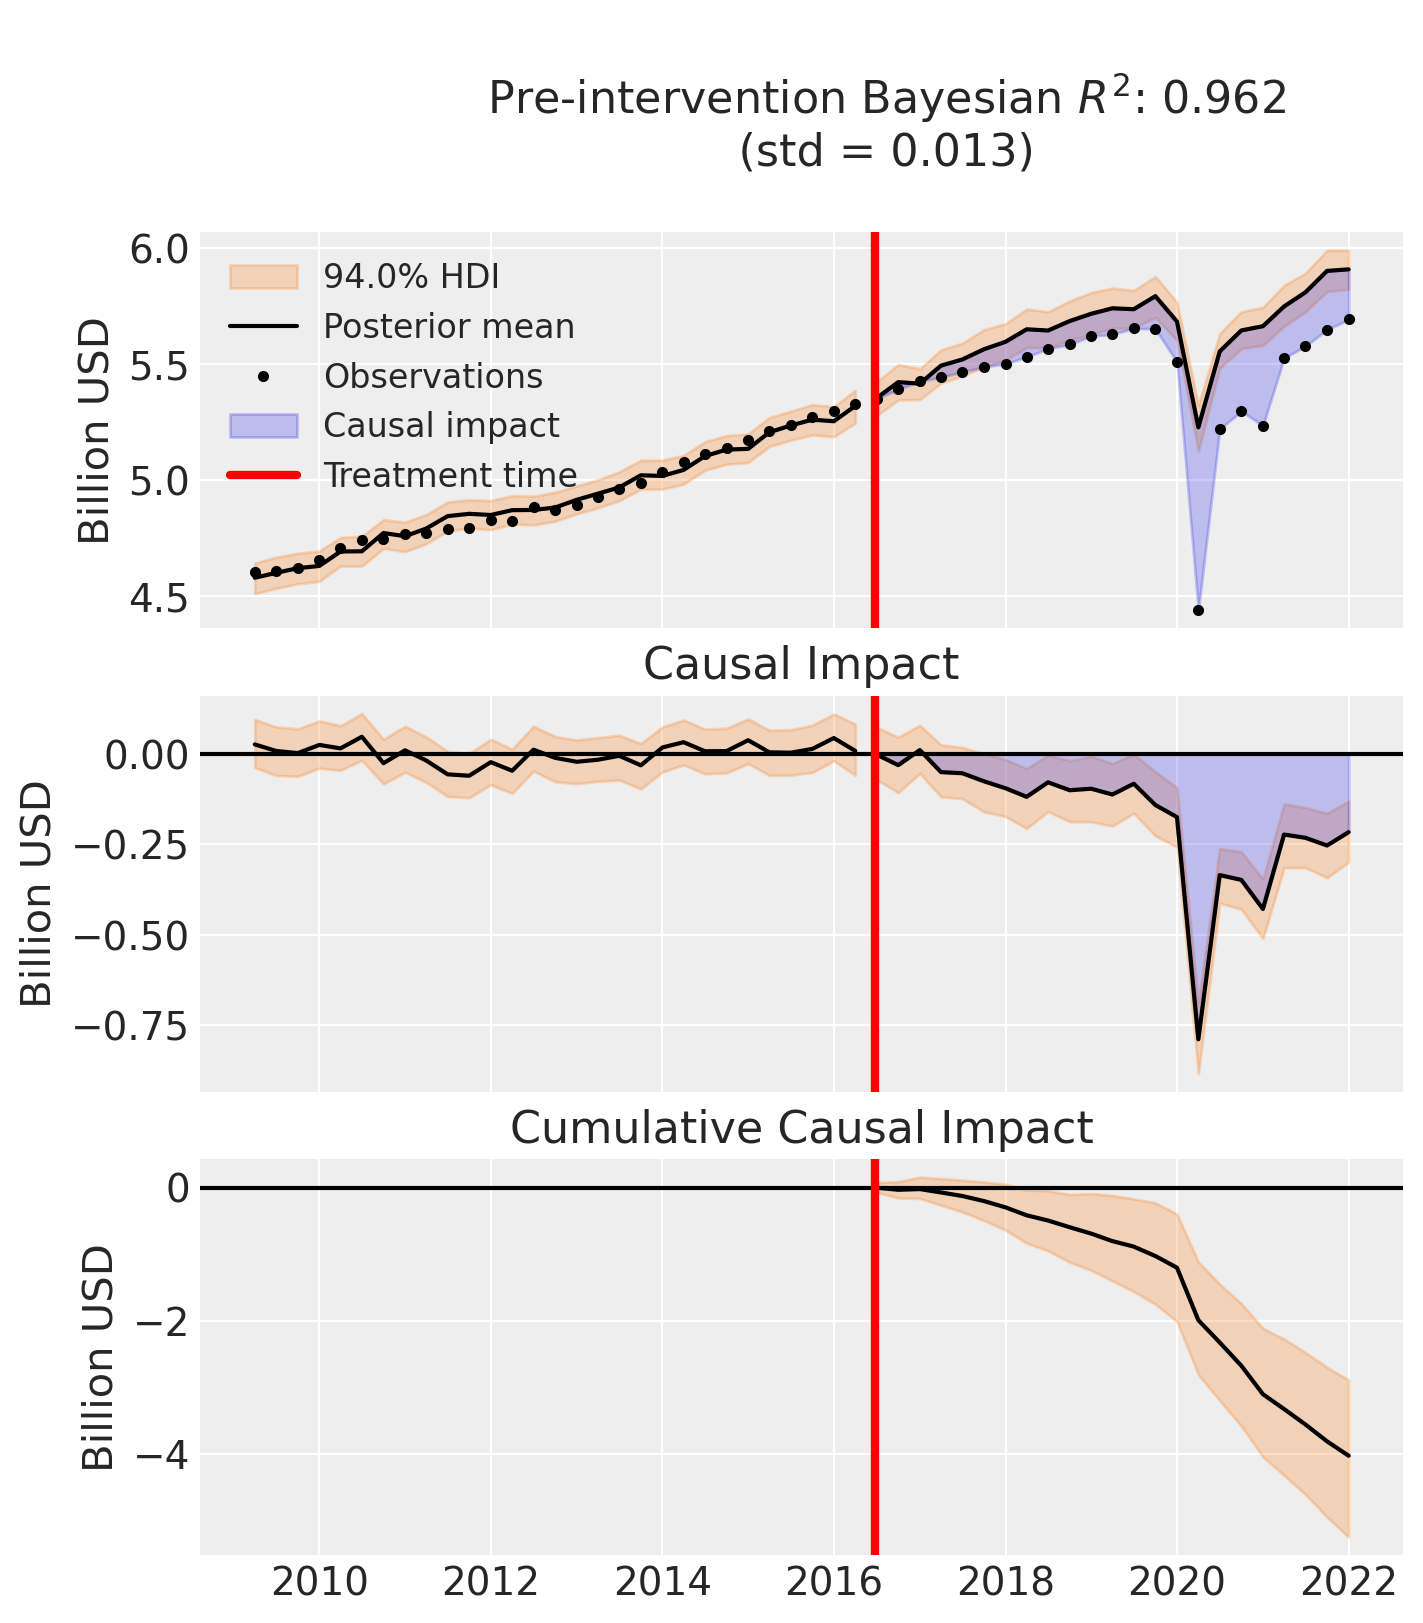

In [12]:
az.style.use("arviz-darkgrid")

fig, ax = result.plot(plot_predictors=False)

for i in [0, 1, 2]:
    ax[i].set(ylabel="Billion USD")

plt.savefig("img/brexit_causal_impact.png", bbox_inches="tight", dpi=300);

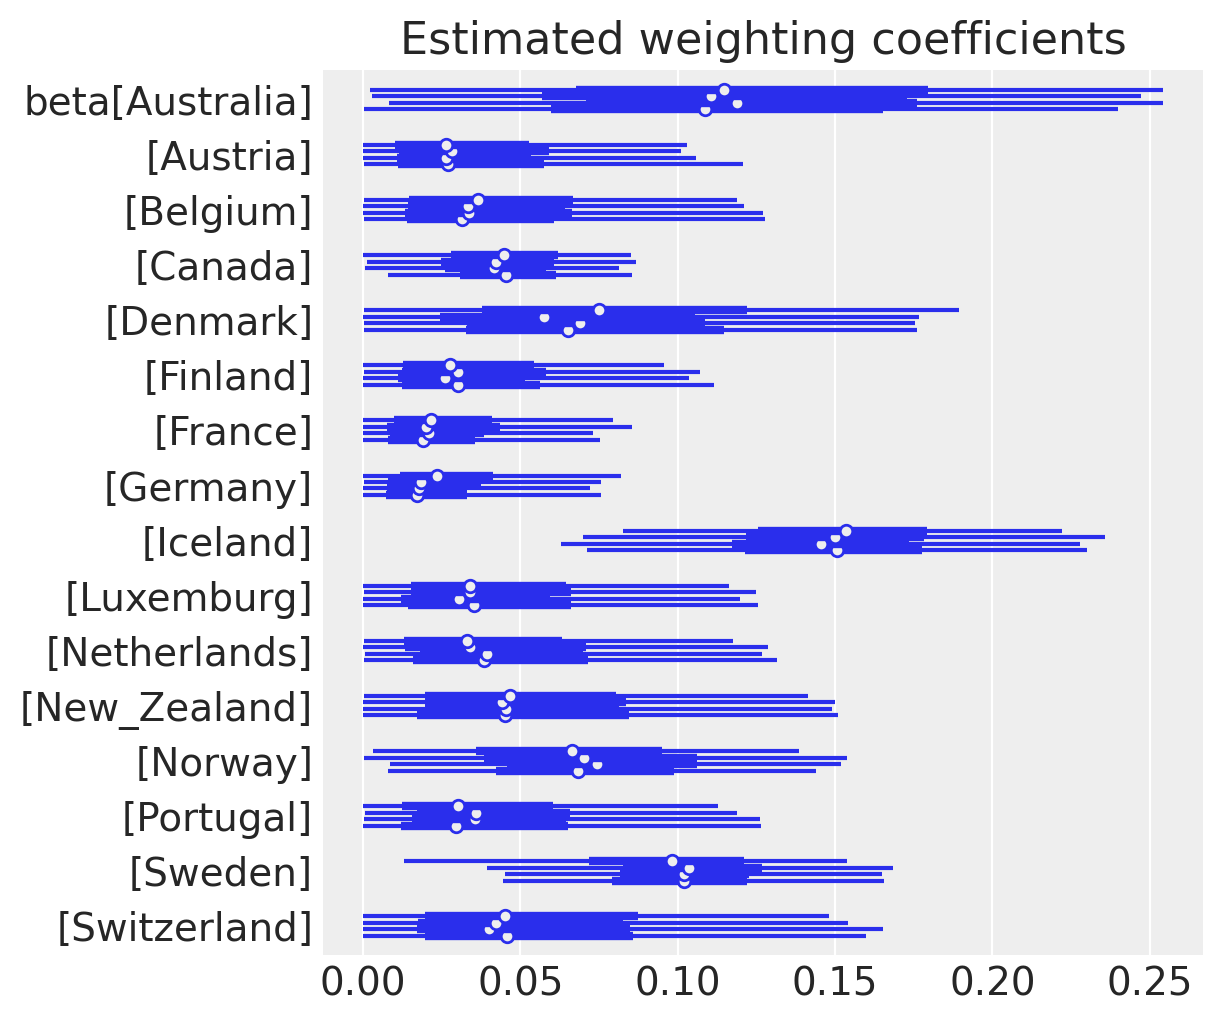

In [13]:
ax = az.plot_forest(result.prediction_model.idata, var_names="beta", figsize=(6, 5))
ax[0].set(title="Estimated weighting coefficients");

In [14]:
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-4.028,0.63,-5.252,-2.89,0.02,0.014,1005.0,1284.0,1.0


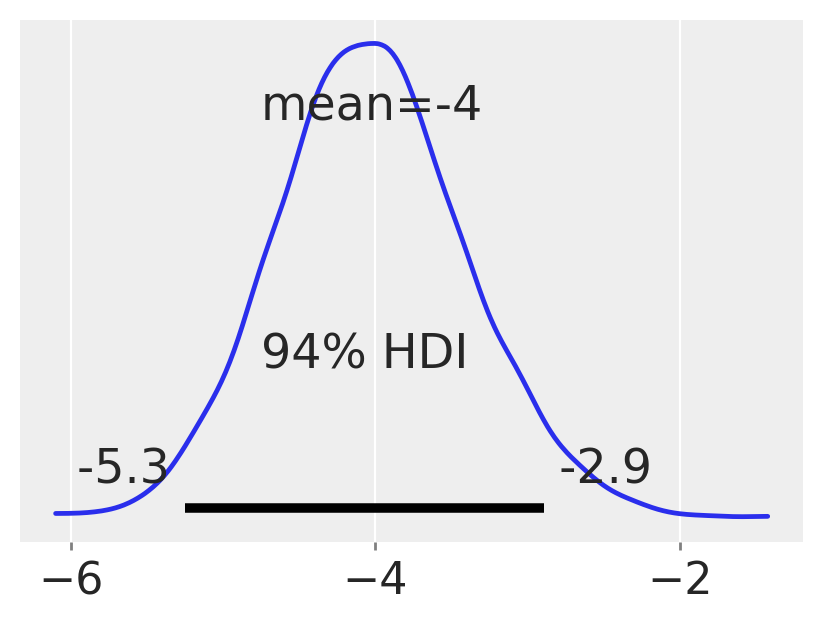

In [15]:
ax = az.plot_posterior(
    last_cumulative_estimate, figsize=(4, 3), textsize=16, round_to=2
)
ax.set(title=None)
plt.savefig("img/brexit_cumulative.png", bbox_inches="tight", dpi=300);